### ***Contributed by:-***

Divyanshi Bhojak(202IT007)

Tarushi Jat (202IT029)

### ***Description:*** 

Classification with CIFAR-10 dataset using Cyclical Learning Rate.
****

### **Necessary Libraries Used**

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-v2a907fk
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-v2a907fk
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=01036e2764168972af039d551d54b638de05898954aefae01b97c9b6d1a6e962
  Stored in directory: /tmp/pip-ephem-wheel-cache-0co2cxn6/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,BatchNormalization
from keras_contrib.callbacks import CyclicLR
import numpy as np 
from keras.optimizers import SGD, Adam
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from keras import regularizers
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
plt.style.use('ggplot')

### **Defining AdamW Optimizer**

In [ ]:
class Optimizer:
    def __init__(self, learning_rate=None, name=None):
        self.learning_rate = learning_rate
        self.name = name

    def config(self, layers):
        # sets up empty cache dictionaries 
        pass

    def optimize(self, idx, layers: list, grads: dict, *args):
        
        pass 

In [ ]:
class AdamW(Adam):  
    
    def __init__(self, learning_rate, gamma_init=1e-5, decay_rate=0.8, **kwargs):
        super().__init__(**kwargs)
        self.learning_rate = learning_rate
        self.gamma_init = gamma_init
        self.decay_rate = decay_rate
    
    def optimize(self, idx, layers, grads, epoch_num, steps):
        gamma = self.gamma_init * self.decay_rate ** int(epoch_num / 5) 
        dW = grads[f'dW{idx}']
        db = grads[f'db{idx}']
        self.m[f'W{idx}'] = self.beta1 * self.m[f'W{idx}'] + (1 - self.beta1) * dW
        self.v[f'W{idx}'] = self.beta2 * self.v[f'W{idx}'] + (1 - self.beta2) * dW ** 2 

        self.m[f'b{idx}'] = self.beta1 * self.m[f'b{idx}'] + (1 - self.beta1) * db
        self.v[f'b{idx}'] = self.beta2 * self.v[f'b{idx}'] + (1 - self.beta2) * db ** 2 

        mt_w  = self.m[f'W{idx}'] / (1 - self.beta1 ** steps)
        vt_w = self.v[f'W{idx}'] / (1 - self.beta2 ** steps)

        mt_b  = self.m[f'b{idx}'] / (1 - self.beta1 ** steps)
        vt_b = self.v[f'b{idx}'] / (1 - self.beta2 ** steps)

        w_update = - self.learning_rate * mt_w / ((np.sqrt(vt_w) + self.epsilon) + gamma * layers[idx].W) 
        b_update = - self.learning_rate * mt_b / ((np.sqrt(vt_b) + self.epsilon) + gamma * layers[idx].b)

        layers[idx].W += w_update
        layers[idx].b += b_update


### **CIFAR-10 Dataset Loading**

In [ ]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

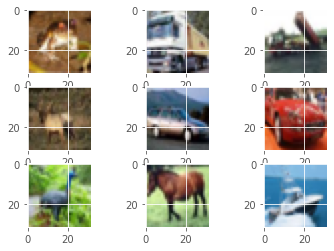

In [ ]:
import matplotlib.pyplot as plt
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# set up image augmentation
datagen = ImageDataGenerator(rotation_range=15, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(x_train)

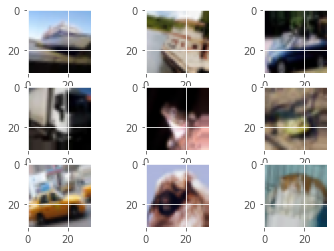

In [ ]:
# see example augmentation images
import numpy as np 
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

### **Image Pre-processing**

In [ ]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [ ]:
# labels
import keras as k
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

### **Performance Metrics Used**
1. Computation & cost time
2. Accuracy
3. Confusion Matrix
4. ROC Curve
5. Classification Report

In [ ]:
def perf_metrics_acc(model):
  score = model.evaluate(x_test,y_test,verbose=0)
  print("Test Loss : {:.4f}".format(score[0]))
  print("Test Accuracy : {:.2f}".format(score[1]*100),"%")

In [ ]:
def per_metrics_2(y_test, pred):
  print("*******************Classification Report*******************\n")
  print(classification_report(y_test, pred))
  print("*******************Confusion Matrix*******************\n")
  print(confusion_matrix(y_test, pred))

### **Plotting Graph Methods**

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def display_cm(y_test, model_pred):
  CM = confusion_matrix(y_test, model_pred)
  f, ax = plt.subplots(figsize=(8,8))
  sns.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()

### **Model Architecture**

In [ ]:
def self_model_arch():

    reg=None
    num_filters=32
    ac='relu'
    adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt=adm
    drop_dense=0.5
    drop_conv=0
    batch_size = 32 
    num_classes = 10

    model = Sequential()

    model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
    model.add(Dropout(drop_conv))

    model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
    model.add(Dropout(drop_conv))

    model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
    model.add(Dropout(drop_conv))

    model.add(Flatten())
    model.add(Dense(512, activation=ac,kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
    return model

In [ ]:
model = self_model_arch()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

### **Cyclical Learning Rate**

In [ ]:
clr = CyclicLR(
    base_lr=0.001,
    max_lr=0.005,
    step_size=2000,
    mode='triangular')

### **Optimizer  Adam**

In [ ]:
model_1 = self_model_arch()
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### **Model Training: with image augmentation**

In [ ]:
m_1 = model_1.fit(datagen.flow(x_train, y_train, batch_size=128),steps_per_epoch = len(x_train) / 128, epochs=50, validation_data=(x_test, y_test), callbacks=[clr], shuffle=True)

Epoch 1/50
390/390 [==============================] - 70s 101ms/step - loss: 1.9959 - accuracy: 0.3828 - val_loss: 1.1667 - val_accuracy: 0.5859
Epoch 2/50
390/390 [==============================] - 40s 103ms/step - loss: 1.1467 - accuracy: 0.5972 - val_loss: 1.1866 - val_accuracy: 0.6390
Epoch 3/50
390/390 [==============================] - 41s 104ms/step - loss: 0.9355 - accuracy: 0.6697 - val_loss: 1.2191 - val_accuracy: 0.6591
Epoch 4/50
390/390 [==============================] - 40s 104ms/step - loss: 0.8377 - accuracy: 0.7067 - val_loss: 0.9511 - val_accuracy: 0.7144
Epoch 5/50
390/390 [==============================] - 41s 105ms/step - loss: 0.7565 - accuracy: 0.7403 - val_loss: 0.8641 - val_accuracy: 0.7279
Epoch 6/50
390/390 [==============================] - 41s 105ms/step - loss: 0.6836 - accuracy: 0.7655 - val_loss: 0.6843 - val_accuracy: 0.7864
Epoch 7/50
390/390 [==============================] - 41s 104ms/step - loss: 0.5916 - accuracy: 0.7966 - val_loss: 0.6345 - val_ac

### **Performance Metrics Analysis for Model with Adam Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model_1)

Test Loss : 0.3624
Test Accuracy : 88.82 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model_1.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1000
           1       0.90      0.97      0.93      1000
           2       0.87      0.86      0.87      1000
           3       0.80      0.79      0.80      1000
           4       0.89      0.90      0.89      1000
           5       0.89      0.77      0.83      1000
           6       0.82      0.97      0.89      1000
           7       0.95      0.89      0.92      1000
           8       0.96      0.90      0.93      1000
           9       0.92      0.93      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

*******************Confusion Matrix*******************

[[904  18  30   2   3   0   6   4  18  15]
 [  2 974   0   1   1   0   1   0   2  19]
 [ 12   1 862  20  18  15  60   5   3 

**3. Visualizing accuracy for every epoch**

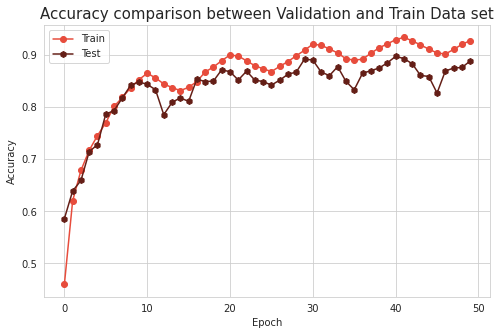

In [ ]:
acc_plot(m_1)

**4. Visualizing loss in every epoch**

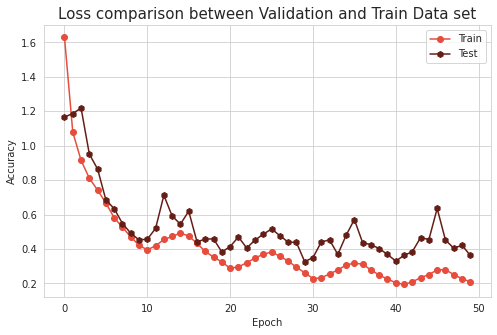

In [ ]:
loss_plot(m_1)

**5. Visualizing Confusion Matrix**

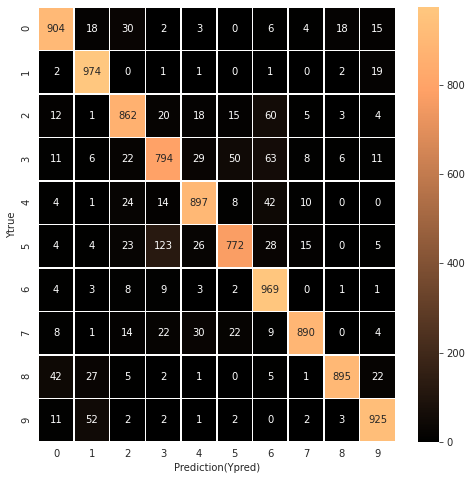

In [ ]:
display_cm(y_test, pred)

**6. Roc Curve**

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_bin.shape[1]
y_pred = label_binarize(pred, classes=[0,1,2,3,4,5,6,7,8,9])

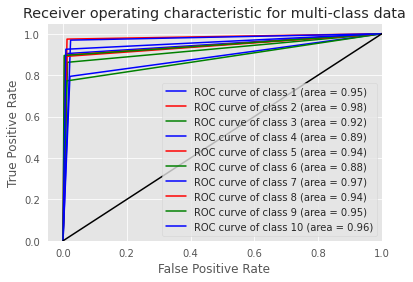

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### **Optimizer  AdamW**

In [ ]:
model_2 = self_model_arch()

model_2.compile(loss='categorical_crossentropy', optimizer= AdamW(0.005), metrics=['accuracy'])

### **Model Training: with image augmentation**

In [ ]:
m_2 = model_2.fit(datagen.flow(x_train, y_train, batch_size=128), steps_per_epoch = len(x_train) / 128, epochs=50, validation_data=(x_test, y_test), callbacks=[clr], shuffle=True)

Epoch 1/50
390/390 [==============================] - 41s 102ms/step - loss: 1.9757 - accuracy: 0.3870 - val_loss: 1.1379 - val_accuracy: 0.5982
Epoch 2/50
390/390 [==============================] - 39s 101ms/step - loss: 1.0530 - accuracy: 0.6235 - val_loss: 1.2904 - val_accuracy: 0.6225
Epoch 3/50
390/390 [==============================] - 39s 100ms/step - loss: 0.9074 - accuracy: 0.6789 - val_loss: 0.9294 - val_accuracy: 0.6972
Epoch 4/50
390/390 [==============================] - 39s 100ms/step - loss: 0.8385 - accuracy: 0.7098 - val_loss: 1.0820 - val_accuracy: 0.6905
Epoch 5/50
390/390 [==============================] - 39s 100ms/step - loss: 0.7687 - accuracy: 0.7341 - val_loss: 1.0927 - val_accuracy: 0.6815
Epoch 6/50
390/390 [==============================] - 40s 104ms/step - loss: 0.7113 - accuracy: 0.7554 - val_loss: 0.7519 - val_accuracy: 0.7590
Epoch 7/50
390/390 [==============================] - 41s 104ms/step - loss: 0.6686 - accuracy: 0.7679 - val_loss: 0.7053 - val_ac

### **Performance Metrics Analysis for Model with AdamW Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model_2)

Test Loss : 0.3712
Test Accuracy : 88.35 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model_2.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1000
           1       0.94      0.94      0.94      1000
           2       0.88      0.83      0.85      1000
           3       0.80      0.74      0.77      1000
           4       0.91      0.85      0.88      1000
           5       0.86      0.80      0.83      1000
           6       0.87      0.95      0.91      1000
           7       0.87      0.94      0.90      1000
           8       0.90      0.95      0.93      1000
           9       0.89      0.94      0.91      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

*******************Confusion Matrix*******************

[[884   7  14   6   1   1   3   9  51  24]
 [  2 938   0   0   1   0   1   0  13  45]
 [ 27   1 832  31  21  22  36  23   5 

**3. Visualizing accuracy for every epoch**

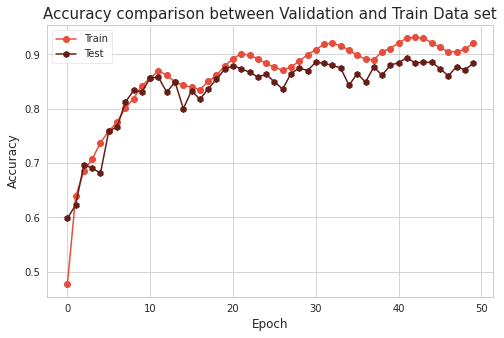

In [ ]:
acc_plot(m_2)

**4. Visualizing loss in every epoch**

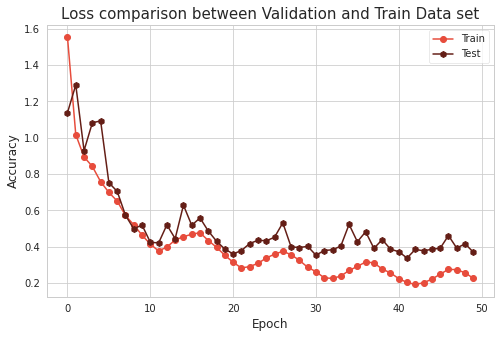

In [ ]:
loss_plot(m_2)

**5. Visualizing Confusion Matrix**

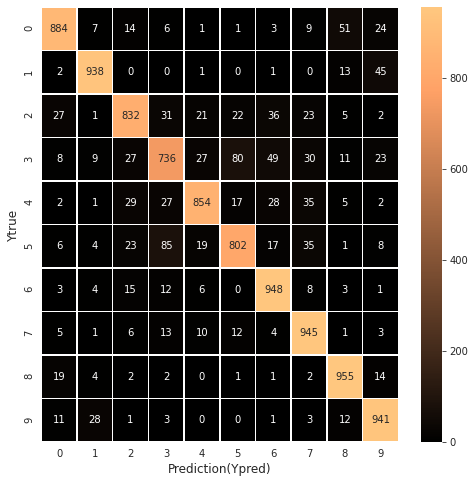

In [ ]:
display_cm(y_test, pred)

**6. Roc Curve**

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_bin.shape[1]
y_pred = label_binarize(pred, classes=[0,1,2,3,4,5,6,7,8,9])

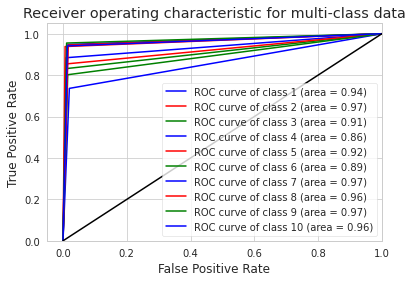

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

### **Optimizer  SGD with Momemtum**

In [ ]:
model_3 = self_model_arch()
opt = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=False)
model_3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### **Model Training: with image augmentation**

In [ ]:
m_3 = model_3.fit(datagen.flow(x_train, y_train, batch_size=128),steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_test, y_test), callbacks=[clr], shuffle=True)

Epoch 1/100
390/390 [==============================] - 42s 105ms/step - loss: 2.4729 - accuracy: 0.2902 - val_loss: 1.3040 - val_accuracy: 0.5293
Epoch 2/100
390/390 [==============================] - 41s 105ms/step - loss: 1.4701 - accuracy: 0.4880 - val_loss: 1.1348 - val_accuracy: 0.6066
Epoch 3/100
390/390 [==============================] - 41s 106ms/step - loss: 1.1879 - accuracy: 0.5775 - val_loss: 1.1091 - val_accuracy: 0.6275
Epoch 4/100
390/390 [==============================] - 41s 105ms/step - loss: 1.0489 - accuracy: 0.6281 - val_loss: 1.0445 - val_accuracy: 0.6624
Epoch 5/100
390/390 [==============================] - 41s 105ms/step - loss: 0.9637 - accuracy: 0.6594 - val_loss: 0.9069 - val_accuracy: 0.6895
Epoch 6/100
390/390 [==============================] - 41s 105ms/step - loss: 0.8809 - accuracy: 0.6927 - val_loss: 0.8034 - val_accuracy: 0.7258
Epoch 7/100
390/390 [==============================] - 41s 105ms/step - loss: 0.7985 - accuracy: 0.7180 - val_loss: 0.7263 -

### **Performance Metrics Analysis for Model with SGD-M Optimizer**

**1. Accuracy**

In [ ]:
perf_metrics_acc(model_3)

Test Loss : 0.4250
Test Accuracy : 87.20 %


**2. Classification Report & Confusion Matrix**

In [ ]:
pred = model_3.predict(x_test, batch_size = 32)
pred = np.argmax(pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
per_metrics_2(y_test, pred)

*******************Classification Report*******************

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1000
           1       0.88      0.97      0.92      1000
           2       0.83      0.84      0.83      1000
           3       0.82      0.68      0.74      1000
           4       0.90      0.84      0.87      1000
           5       0.86      0.77      0.81      1000
           6       0.78      0.96      0.86      1000
           7       0.91      0.93      0.92      1000
           8       0.95      0.92      0.93      1000
           9       0.92      0.92      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

*******************Confusion Matrix*******************

[[893  16  34   3   8   0   6   4  24  12]
 [  4 969   0   0   0   0   0   0   4  23]
 [ 23   4 843  17  16  18  57  12   5 

**3. Visualizing accuracy for every epoch**

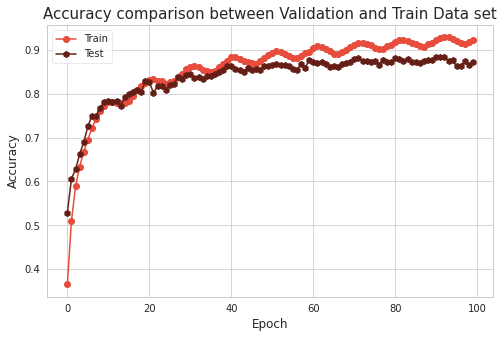

In [ ]:
acc_plot(m_3)

**4. Visualizing loss in every epoch**

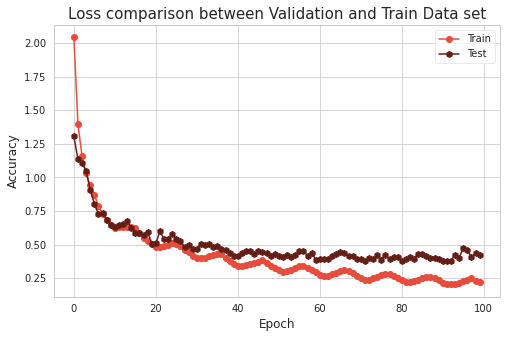

In [ ]:
loss_plot(m_3)

**5. Visualizing Confusion Matrix**

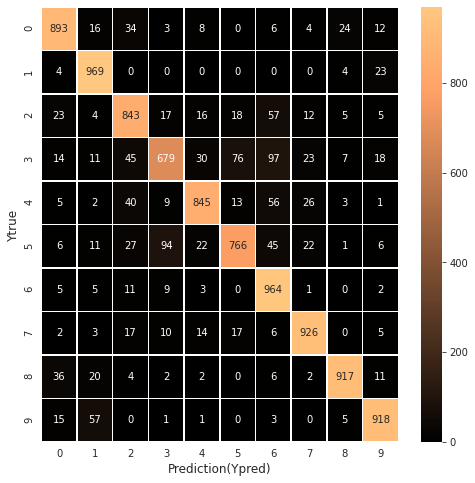

In [ ]:
display_cm(y_test, pred)

**6. Roc Curve**

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
y_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_bin.shape[1]
y_pred = label_binarize(pred, classes=[0,1,2,3,4,5,6,7,8,9])

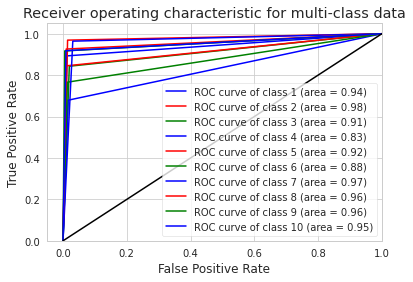

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k-', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

**END.**